In [1]:
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import datetime
import matplotlib.dates as mdates
import os
import warnings
import re
from wrf import to_np

date_fmt = mdates.DateFormatter('%d-%m'+'\n'+ '%H:%M')
plt.rcParams['figure.facecolor']='white'

In [2]:
WProf_datas = "./WProf_data/*ZEN_LV1*"


mdv_plot = None
Ze_plot = None
Rgates_plot = None
Spectral_width_plot = None

x_axis = np.array([])

for element in sorted(glob.glob(WProf_datas)):
    nc = Dataset(element)
    dt = [datetime.datetime.utcfromtimestamp(tt) for tt in nc.variables['Time']]

    if dt[-1] < datetime.datetime(2021, 12, 17, 18):
        continue

    if dt[-1] > datetime.datetime(2021, 12, 19, 12):
        continue 
    
    mdv = nc.variables['Mean-velocity'][:]
    Ze = 10*np.log10(nc.variables['Ze'][:])
    SNR = 10*np.log10(nc.variables['Ze'][:]/nc.variables['Linear-sensitivity-vert'][:])
    mdv[SNR<26]=np.nan # This seems to be an appropriate threshold to filter out noise
    
    Rgates = nc.variables['Rgate'][:]/1000
    Spectral_width = nc.variables['Spectral-width'][:]
    
    # test du snr
    #Ze.mask = SNR<-24
    Ze[SNR<30]=np.nan
    Spectral_width[SNR<26]= np.nan
    
    if mdv_plot is None:
        mdv_plot = mdv 
    else:
        mdv_plot = np.concatenate((mdv_plot, mdv), axis=0)  
    
    if Ze_plot is None:
        Ze_plot = Ze  
    else:
        Ze_plot = np.concatenate((Ze_plot, Ze), axis=0)  
    
    if Rgates_plot is None:
        Rgates_plot = Rgates  
    else:
        Rgates_plot = np.concatenate((Rgates_plot, Rgates), axis=0) 

    if Spectral_width_plot is None:
        Spectral_width_plot = Spectral_width
    else:
        Spectral_width_plot = np.concatenate((Spectral_width_plot, Spectral_width), axis=0) 
    
    
    x_axis = np.append(x_axis, dt)

In [3]:
#suppress warnings
warnings.filterwarnings('ignore')


###################################
# Model Outputs - Pick file       #
###################################

# find all files starting with "Output" and ending in ".nc" but not containing "_"
pattern = re.compile(r'^Output[^_]*\.nc$')

# get a list of all files in the current directory
files = os.listdir('cr-sim')

# filter the files using the regular expression
filelist = [file for file in files if pattern.match(file)]

nfiles = len(filelist)

# Initialize empty numpy array
REFL = np.empty((nfiles, 97))
DOPPLER = np.empty((nfiles, 97))
SP_WIDTH = np.empty((nfiles, 97))
print(nfiles)

current = os.getcwd()
os.chdir(os.path.join(current, "cr-sim"))

# Loop over files and append data
#for i, fn in enumerate(filelist):
for i, fn in enumerate(sorted(filelist, key=lambda x: int(re.findall(r'\d+', x)[0]))):
    
    ds = Dataset(fn)
    
    refl = np.squeeze(np.array(ds.variables['Zhh'][:]))  ##Reflectivity at hh polarization, dBz
    REFL[i] = refl
    
    doppler = np.squeeze(np.array(ds.variables['DV'][:]))  ##Radial Doppler velocity, positive upward [m/s]
    DOPPLER[i] = doppler
    
    sp_width = np.squeeze(np.array(ds.variables['SWtot'][:]))  ##Radial Doppler velocity, positive upward [m/s]
    SP_WIDTH[i] = sp_width

# Check shape of array
print(REFL.shape)


REFL[REFL==-999.0] = np.nan; DOPPLER[DOPPLER==-999.0] = np.nan; SP_WIDTH[SP_WIDTH==-999.0] = np.nan

wrf_time = np.arange(np.datetime64('2021-12-17T00:00'), np.datetime64('2021-12-19T12:01'),dtype='datetime64[m]')[::30]

os.chdir('..')
### Read the altitude of the WRF model levels
# /!\ change this path
simu_CONTROL = 'wrfout_Helmos_d03_CONTROL_LONGER_VL.nc' 
ncCNT = Dataset(simu_CONTROL)

PHB = np.squeeze(ncCNT.variables["PHB"][0,:])
PH = np.squeeze(ncCNT.variables["PH"][0,:])
HGT = np.squeeze(ncCNT.variables["HGT"][0])
ZZASL = (PH+PHB)/9.81
ZZ = (PH+PHB)/9.81-HGT
dz=np.zeros((len(ZZ)-1))        #height difference between consecutive vertical levels
ZZmiddle=np.zeros((len(ZZ)-1))  #height in the middle of each grid box

kk = 0

for jj in range(len(ZZ)-1):
        dz[kk] = (ZZ[kk+1]-ZZ[kk])/2
        ZZmiddle[kk] = dz[kk] + ZZ[kk]
        kk=kk+1


spin_up = 42
end = 120+1

#os.chdir('..')

120
(120, 97)


In [4]:
### WRF constants
RA=287.15
RD=287.0
CP=1004.5
P1000MB=100000.0
EPS=0.622

presCNT = np.squeeze(ncCNT.variables['P'][:] + ncCNT.variables['PB'][:])

thetCNT = np.squeeze(ncCNT.variables['T'][:] + 300.0)

qvCNT = np.squeeze(ncCNT.variables['QVAPOR'][:])

tkCNT = ((presCNT / P1000MB)**(RD/CP) * thetCNT)

tCNT = tkCNT - 273.15 #Temperature in Celsius degrees

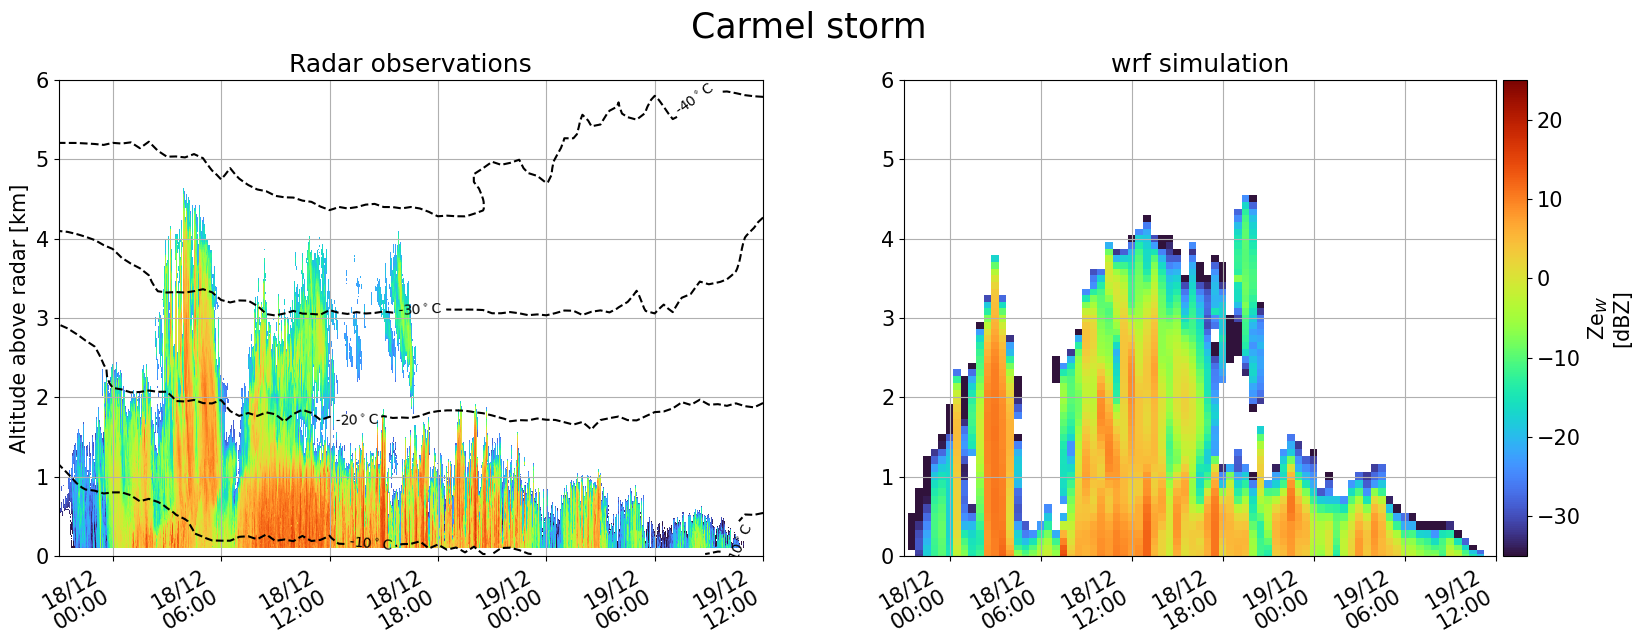

In [5]:
'''cs = axs[0].contour(wrf_time[spin_up:end],
ZZmiddle/1000, (tCNT.T)[:,spin_up:end],
levels=np.arange(-50, 0,
10), colors='black')

axs[0].clabel(cs, inline=True,
fontsize=10, fmt='%d$^\circ$C')

axs[0].set_xlim(wrf_time[spin_up],
wrf_time[end-1])'''

plt.rcParams['font.size']=15
fig,axs = plt.subplots(1,2,figsize=(20,7),sharex=True)
fig.suptitle('Carmel storm', fontsize=25)

im0=axs[0].pcolormesh(x_axis,Rgates,Ze_plot.T,vmin=-35,vmax=25,cmap='turbo')

axs[0].set_ylabel('Altitude above radar [km]')
axs[0].set_title('Radar observations')

axs[0].grid()

axs[0].set_ylim(0,6)

# Isoterm
cs = axs[0].contour(wrf_time[spin_up:end],ZZmiddle/1000, (tCNT.T)[:,spin_up:end],levels=np.arange(-50, 0,10), colors='black')
axs[0].clabel(cs, inline=True,fontsize=10, fmt='%d$^\circ$C')
# ???
#axs[0].set_xlim(wrf_time[spin_up],wrf_time[end-1])

reflectivity = axs[1].pcolormesh(to_np(wrf_time[spin_up:end]),to_np(ZZ)/1000,REFL[spin_up-1:end].T,vmin=-35,vmax=25,cmap='turbo')

axs[1].set_xlim(wrf_time[spin_up], wrf_time[end-1])
axs[1].set_title('wrf simulation')

axs[1].set_ylim(0,6)
axs[1].set_yticks([0,1,2,3,4,5,6])
axs[1].grid()

xfmt = mdates.DateFormatter('%d/%m' +'\n'+ '%H:%M')
xlocator = mdates.MinuteLocator(interval = 360)
axs[1].xaxis.set_major_locator(xlocator)
axs[1].xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
plt.colorbar(reflectivity,label=r'Ze$_{W}$'+'\n[dBZ]',pad=.01,ax=axs[1])